# 
<center><h1> Homework 1: Multilayer Perceptrons and Stochastic Gradient Descent </h1></center>
<center> Apoorv Sharma </center>
    <center> DATA 598 (Winter 2022), University of Washington </center>

In this exercise, we will experiment with the number of hidden units in a multilayer perceptron (MLP) with
a single hidden layer. The number of hidden units is also referred to the width of the hidden layer.
Here are the details:
* The setup is identical to the demo/lab and you may reuse that code. Take the FashionMNIST dataset and randomly subsample 10% of its training set to work with. As a test set, we will use the full test set of FashionMNIST.
* Define a MLP with one hidden layer of width h = 32. Find the divergent learning rate η for this model and use a fixed learning rate of η/2, as we discussed in class.
* Train the model for 100 passes over the data.
* Repeat this procedure for widths h = 8, 16, 128, 512 with the same learning rate η/2 as above (i.e., you do not need to find the divergent learning rate of each model for this exercise).

In [60]:
import numpy as np
import torch
from torchvision.datasets import FashionMNIST
from torch.nn.functional import cross_entropy
import time
import copy
import os

from pprint import pprint as pp

import matplotlib.pyplot as plt 
%matplotlib inline 

torch.manual_seed(0)
np.random.seed(1)

In [2]:
MLP_Q1_RESULTS_FILE = 'models/hw1_q1_fashion_mlp_summary.pt' 
MLP_Q2_RESULTS_FILE = 'models/hw1_q2_fashion_mlp_summary.pt'

Download the FashionMNIST dataset and subsample 10% of it

In [3]:
# download dataset (~117M in size)
train_dataset = FashionMNIST('./data/train', train=True, download=True)
X_train = train_dataset.data # torch tensor of type uint8
y_train = train_dataset.targets # torch tensor of type Long

test_dataset = FashionMNIST('./data/test', train=False, download=True)
X_test = test_dataset.data
y_test = test_dataset.targets

# choose a subsample of 10% of the data:
idxs_train = torch.from_numpy(
    np.random.choice(X_train.shape[0], replace=False, size=X_train.shape[0]//10))
X_train, y_train = X_train[idxs_train], y_train[idxs_train]

print(f'X_train.shape = {X_train.shape}')
print(f'n_train: {X_train.shape[0]}, n_test: {X_test.shape[0]}')
print(f'Image size: {X_train.shape[1:]}')

X_train.shape = torch.Size([6000, 28, 28])
n_train: 6000, n_test: 10000
Image size: torch.Size([28, 28])


In [4]:
# Normalize dataset: pixel values lie between 0 and 255
# Normalize them so the pixelwise mean is zero and standard deviation is 1

X_train = X_train.float()  # convert to float32
X_train = X_train.view(-1, 784)  # flatten into a (n, d) shape
mean, std = X_train.mean(axis=0), X_train.std(axis=0)
X_train = (X_train - mean[None, :]) / (std[None, :] + 1e-6)  # avoid divide by zero

X_test = X_test.float()
X_test = X_test.view(-1, 784)
X_test = (X_test - mean[None, :]) / (std[None, :] + 1e-6)

n_class = np.unique(y_train).shape[0]

In [5]:
# Some utility functions to compute the objective and the accuracy

def mlp(X, ws, bs):
    hidden = X # Shape: (n, d_0)
    for w, b in zip(ws[:-1], bs[:-1]):
        hidden = torch.matmul(hidden, w) + b[None, :]  # Shape: (n, d_{j-1}) * (d_{j-1}, d_j) = (n, d_j)
        hidden = torch.nn.functional.relu(hidden)
    return torch.matmul(hidden, ws[-1]) + bs[-1][None, :]

def compute_objective(ws, bs, X, y, reg_param):
    """ Compute the multinomial logistic loss. 
        ws is a list of tensors of consistent shapes,
        X of shape (n, d) and y of shape (n,)
    """
    score = mlp(X, ws, bs)  # Shape: (n, K)
    # PyTorch's function cross_entropy computes the multinomial logistic loss
    return (
        cross_entropy(input=score, target=y, reduction='mean') 
        + 0.5 * reg_param * sum([torch.norm(w)**2 for w in ws])
    )

@torch.no_grad()
def compute_accuracy(ws, bs, X, y):
    """ Compute the classification accuracy
        ws is a list of tensors of consistent shapes 
        X of shape (n, d) and y of shape (n,)
    """
    score = mlp(X, ws, bs)  # shape: (n, K`)
    predictions = torch.argmax(score, axis=1)  # class with highest score is predicted
    return (predictions == y).sum() * 1.0 / y.shape[0]

@torch.no_grad()
def compute_logs(ws, bs, reg_param, verbose=False):
    train_loss = compute_objective(ws, bs, X_train, y_train, reg_param)
    test_loss = compute_objective(ws, bs, X_test, y_test, reg_param)
    train_accuracy = compute_accuracy(ws, bs, X_train, y_train)
    test_accuracy = compute_accuracy(ws, bs, X_test, y_test)
    if verbose:
        print(('Train Loss = {:.3f}, Train Accuracy = {:.3f}, ' + 
               'Test Loss = {:.3f}, Test Accuracy = {:.3f}').format(
                train_loss.item(), train_accuracy.item(), 
                test_loss.item(), test_accuracy.item())
    )
    return (train_loss, train_accuracy, test_loss, test_accuracy)

In [6]:
def intialize_ws(hidden_size, n_class):
    ws = [1e-6 * torch.randn(784, hidden_size, requires_grad=True),
          1e-6 * torch.randn(hidden_size, n_class, requires_grad=True)]
    return ws

def initialize_bs(hidden_size, n_class):
    bs = [torch.zeros(hidden_size, requires_grad=True),
          torch.zeros(n_class, requires_grad=True)]
    return bs

In [7]:
def sgd_one_pass(ws, bs, X, y, reg_param, learning_rate, verbose=False):
    num_examples = X.shape[0]
    average_loss = 0.0
    for i in range(num_examples):
        idx = np.random.choice(X.shape[0])
        # compute the objective. 
        # Note: This function requires X to be of shape (n,d). In this case, n=1 
        objective = compute_objective(ws, bs, X[idx:idx+1], y[idx:idx+1], reg_param) 
        average_loss = 0.99 * average_loss + 0.01 * objective.item()
        if verbose and (i+1) % 100 == 0:
            print(average_loss)
        
        # compute the gradient using automatic differentiation
        all_parameters = [*ws, *bs]
        gradients = torch.autograd.grad(outputs=objective, inputs=all_parameters)
        
        # perform SGD update. IMPORTANT: Make the update inplace!
        with torch.no_grad():
            for (w, g) in zip(all_parameters, gradients):
                w -= learning_rate * g
    return ws, bs

In [8]:
# reg_param = 0.1 / X_train.shape[0]
reg_param = 0

Find the divergent learning rate

In [9]:
learning_rate = 0.01 / 2

hidden_size = 32
ws = intialize_ws(hidden_size, n_class)
bs = initialize_bs(hidden_size, n_class)

_ = compute_logs(ws, bs, reg_param, verbose=True)

ws, bs = sgd_one_pass(ws, bs, X_train, y_train, reg_param, learning_rate, verbose=True)
_ = compute_logs(ws, bs, reg_param, verbose=True)


Train Loss = 2.303, Train Accuracy = 0.094, Test Loss = 2.303, Test Accuracy = 0.096
1.4596734945436483
1.9945874147627942
2.1907702811847978
2.262258175462675
2.288168216893089
2.2950623880166683
2.298219839564293
2.302896123190581
2.30257610207377
2.2915321294114945
2.280852721102953
2.126430165573341
1.9287736125690487
1.8493492605486324
1.7123184657147137
1.5586019151842219
1.4214616694003144
1.390881504237791
1.3405923644022517
1.1929667180198427
1.1020713150444366
1.070320012709279
0.9729690050926664
0.9245819557951745
0.8588912656283177
0.9412617632724704
0.9733787434576562
0.901405160316614
0.9182102662294258
0.7444109468615022
0.8170800067544532
0.7932568922523444
0.8063622863686092
0.741420326250601
0.7817283040031301
0.6811794254503886
0.694335086149683
0.6539764663752585
0.7827460163532026
0.734852175898242
0.5769021581364675
0.609761253720165
0.574642390944477
0.6409038684058812
0.5790878158547016
0.6099915783967417
0.6605070878151497
0.6063592603720036
0.651159947928013
0

Run the data for 100 passes over the data

In [10]:
logs = []
num_passes = 100

if not os.path.exists(MLP_Q1_RESULTS_FILE):
    ws = intialize_ws(hidden_size, n_class)
    bs = initialize_bs(hidden_size, n_class)
    logs.append(compute_logs(ws, bs, reg_param, verbose=True))

    for j in range(num_passes):
        print(j+1, end=', ')
        ws, bs = sgd_one_pass(ws, bs, X_train, y_train, reg_param, learning_rate, verbose=False)
        logs.append(compute_logs(ws, bs, reg_param, verbose=True))

Train Loss = 2.303, Train Accuracy = 0.052, Test Loss = 2.303, Test Accuracy = 0.051
1, Train Loss = 0.580, Train Accuracy = 0.787, Test Loss = 0.615, Test Accuracy = 0.776
2, Train Loss = 0.423, Train Accuracy = 0.848, Test Loss = 0.532, Test Accuracy = 0.820
3, Train Loss = 0.412, Train Accuracy = 0.849, Test Loss = 0.578, Test Accuracy = 0.808
4, Train Loss = 0.417, Train Accuracy = 0.852, Test Loss = 0.623, Test Accuracy = 0.795
5, Train Loss = 0.354, Train Accuracy = 0.869, Test Loss = 0.618, Test Accuracy = 0.800
6, Train Loss = 0.311, Train Accuracy = 0.887, Test Loss = 0.610, Test Accuracy = 0.816
7, Train Loss = 0.288, Train Accuracy = 0.901, Test Loss = 0.585, Test Accuracy = 0.819
8, Train Loss = 0.265, Train Accuracy = 0.909, Test Loss = 0.611, Test Accuracy = 0.809
9, Train Loss = 0.268, Train Accuracy = 0.901, Test Loss = 0.663, Test Accuracy = 0.810
10, Train Loss = 0.207, Train Accuracy = 0.923, Test Loss = 0.629, Test Accuracy = 0.828
11, Train Loss = 0.212, Train Accu

93, Train Loss = 0.001, Train Accuracy = 1.000, Test Loss = 1.578, Test Accuracy = 0.828
94, Train Loss = 0.001, Train Accuracy = 1.000, Test Loss = 1.582, Test Accuracy = 0.828
95, Train Loss = 0.001, Train Accuracy = 1.000, Test Loss = 1.583, Test Accuracy = 0.828
96, Train Loss = 0.001, Train Accuracy = 1.000, Test Loss = 1.587, Test Accuracy = 0.829
97, Train Loss = 0.001, Train Accuracy = 1.000, Test Loss = 1.590, Test Accuracy = 0.828
98, Train Loss = 0.001, Train Accuracy = 1.000, Test Loss = 1.593, Test Accuracy = 0.828
99, Train Loss = 0.001, Train Accuracy = 1.000, Test Loss = 1.594, Test Accuracy = 0.828
100, Train Loss = 0.001, Train Accuracy = 1.000, Test Loss = 1.595, Test Accuracy = 0.828


## 1. Performance vs. Width

In [11]:
num_passes = 100
hidden_sizes = [8, 16, 32, 128, 512]

if not os.path.exists(MLP_Q1_RESULTS_FILE):
    hidden_size_logs = {}
    for hidden_size in hidden_sizes:
        print(f'Hidden Size: {hidden_size}')
        hidden_size_logs[hidden_size] =[]

        ws = intialize_ws(hidden_size, n_class)
        bs = initialize_bs(hidden_size, n_class)
        hidden_size_logs[hidden_size].append(compute_logs(ws, bs, reg_param, verbose=True))

        for j in range(num_passes):
            print(f'\t{j+1}', end=', ')
            ws, bs = sgd_one_pass(ws, bs, X_train, y_train, reg_param, learning_rate, verbose=False)
            hidden_size_logs[hidden_size].append(compute_logs(ws, bs, reg_param, verbose=True))

        print()

Hidden Size: 8
Train Loss = 2.303, Train Accuracy = 0.098, Test Loss = 2.303, Test Accuracy = 0.099
	1, Train Loss = 0.637, Train Accuracy = 0.763, Test Loss = 0.673, Test Accuracy = 0.754
	2, Train Loss = 0.491, Train Accuracy = 0.822, Test Loss = 0.593, Test Accuracy = 0.791
	3, Train Loss = 0.469, Train Accuracy = 0.830, Test Loss = 0.580, Test Accuracy = 0.799
	4, Train Loss = 0.507, Train Accuracy = 0.808, Test Loss = 0.664, Test Accuracy = 0.770
	5, Train Loss = 0.388, Train Accuracy = 0.862, Test Loss = 0.592, Test Accuracy = 0.810
	6, Train Loss = 0.456, Train Accuracy = 0.830, Test Loss = 0.667, Test Accuracy = 0.783
	7, Train Loss = 0.360, Train Accuracy = 0.864, Test Loss = 0.607, Test Accuracy = 0.805
	8, Train Loss = 0.377, Train Accuracy = 0.862, Test Loss = 0.664, Test Accuracy = 0.786
	9, Train Loss = 0.380, Train Accuracy = 0.869, Test Loss = 0.700, Test Accuracy = 0.797
	10, Train Loss = 0.353, Train Accuracy = 0.869, Test Loss = 0.680, Test Accuracy = 0.790
	11, Trai

	91, Train Loss = 0.113, Train Accuracy = 0.954, Test Loss = 1.926, Test Accuracy = 0.777
	92, Train Loss = 0.089, Train Accuracy = 0.965, Test Loss = 1.951, Test Accuracy = 0.782
	93, Train Loss = 0.108, Train Accuracy = 0.960, Test Loss = 1.953, Test Accuracy = 0.785
	94, Train Loss = 0.157, Train Accuracy = 0.941, Test Loss = 2.102, Test Accuracy = 0.777
	95, Train Loss = 0.104, Train Accuracy = 0.960, Test Loss = 2.033, Test Accuracy = 0.779
	96, Train Loss = 0.193, Train Accuracy = 0.939, Test Loss = 2.269, Test Accuracy = 0.768
	97, Train Loss = 0.147, Train Accuracy = 0.951, Test Loss = 2.081, Test Accuracy = 0.780
	98, Train Loss = 0.111, Train Accuracy = 0.957, Test Loss = 2.105, Test Accuracy = 0.782
	99, Train Loss = 0.118, Train Accuracy = 0.956, Test Loss = 2.144, Test Accuracy = 0.772
	100, Train Loss = 0.106, Train Accuracy = 0.959, Test Loss = 2.095, Test Accuracy = 0.781

Hidden Size: 16
Train Loss = 2.303, Train Accuracy = 0.106, Test Loss = 2.303, Test Accuracy = 0.1

	81, Train Loss = 0.030, Train Accuracy = 0.990, Test Loss = 1.948, Test Accuracy = 0.812
	82, Train Loss = 0.041, Train Accuracy = 0.986, Test Loss = 1.994, Test Accuracy = 0.798
	83, Train Loss = 0.026, Train Accuracy = 0.991, Test Loss = 2.006, Test Accuracy = 0.805
	84, Train Loss = 0.008, Train Accuracy = 0.998, Test Loss = 1.937, Test Accuracy = 0.811
	85, Train Loss = 0.007, Train Accuracy = 0.999, Test Loss = 1.957, Test Accuracy = 0.809
	86, Train Loss = 0.010, Train Accuracy = 0.997, Test Loss = 1.969, Test Accuracy = 0.809
	87, Train Loss = 0.007, Train Accuracy = 0.998, Test Loss = 2.012, Test Accuracy = 0.808
	88, Train Loss = 0.008, Train Accuracy = 0.998, Test Loss = 2.013, Test Accuracy = 0.809
	89, Train Loss = 0.004, Train Accuracy = 0.999, Test Loss = 2.028, Test Accuracy = 0.810
	90, Train Loss = 0.004, Train Accuracy = 0.999, Test Loss = 2.039, Test Accuracy = 0.809
	91, Train Loss = 0.003, Train Accuracy = 0.999, Test Loss = 2.052, Test Accuracy = 0.809
	92, Train

	71, Train Loss = 0.001, Train Accuracy = 1.000, Test Loss = 1.424, Test Accuracy = 0.832
	72, Train Loss = 0.001, Train Accuracy = 1.000, Test Loss = 1.430, Test Accuracy = 0.832
	73, Train Loss = 0.001, Train Accuracy = 1.000, Test Loss = 1.434, Test Accuracy = 0.832
	74, Train Loss = 0.001, Train Accuracy = 1.000, Test Loss = 1.436, Test Accuracy = 0.832
	75, Train Loss = 0.001, Train Accuracy = 1.000, Test Loss = 1.439, Test Accuracy = 0.831
	76, Train Loss = 0.001, Train Accuracy = 1.000, Test Loss = 1.446, Test Accuracy = 0.832
	77, Train Loss = 0.001, Train Accuracy = 1.000, Test Loss = 1.450, Test Accuracy = 0.832
	78, Train Loss = 0.001, Train Accuracy = 1.000, Test Loss = 1.451, Test Accuracy = 0.832
	79, Train Loss = 0.001, Train Accuracy = 1.000, Test Loss = 1.456, Test Accuracy = 0.831
	80, Train Loss = 0.001, Train Accuracy = 1.000, Test Loss = 1.460, Test Accuracy = 0.832
	81, Train Loss = 0.001, Train Accuracy = 1.000, Test Loss = 1.465, Test Accuracy = 0.831
	82, Train

	61, Train Loss = 0.001, Train Accuracy = 1.000, Test Loss = 1.196, Test Accuracy = 0.842
	62, Train Loss = 0.001, Train Accuracy = 1.000, Test Loss = 1.197, Test Accuracy = 0.842
	63, Train Loss = 0.001, Train Accuracy = 1.000, Test Loss = 1.200, Test Accuracy = 0.841
	64, Train Loss = 0.001, Train Accuracy = 1.000, Test Loss = 1.202, Test Accuracy = 0.842
	65, Train Loss = 0.001, Train Accuracy = 1.000, Test Loss = 1.203, Test Accuracy = 0.842
	66, Train Loss = 0.001, Train Accuracy = 1.000, Test Loss = 1.208, Test Accuracy = 0.842
	67, Train Loss = 0.001, Train Accuracy = 1.000, Test Loss = 1.212, Test Accuracy = 0.842
	68, Train Loss = 0.001, Train Accuracy = 1.000, Test Loss = 1.212, Test Accuracy = 0.842
	69, Train Loss = 0.001, Train Accuracy = 1.000, Test Loss = 1.216, Test Accuracy = 0.841
	70, Train Loss = 0.001, Train Accuracy = 1.000, Test Loss = 1.220, Test Accuracy = 0.841
	71, Train Loss = 0.001, Train Accuracy = 1.000, Test Loss = 1.221, Test Accuracy = 0.842
	72, Train

	51, Train Loss = 0.001, Train Accuracy = 1.000, Test Loss = 1.071, Test Accuracy = 0.844
	52, Train Loss = 0.001, Train Accuracy = 1.000, Test Loss = 1.075, Test Accuracy = 0.843
	53, Train Loss = 0.001, Train Accuracy = 1.000, Test Loss = 1.076, Test Accuracy = 0.845
	54, Train Loss = 0.001, Train Accuracy = 1.000, Test Loss = 1.080, Test Accuracy = 0.844
	55, Train Loss = 0.001, Train Accuracy = 1.000, Test Loss = 1.084, Test Accuracy = 0.844
	56, Train Loss = 0.001, Train Accuracy = 1.000, Test Loss = 1.086, Test Accuracy = 0.844
	57, Train Loss = 0.001, Train Accuracy = 1.000, Test Loss = 1.086, Test Accuracy = 0.844
	58, Train Loss = 0.001, Train Accuracy = 1.000, Test Loss = 1.091, Test Accuracy = 0.844
	59, Train Loss = 0.001, Train Accuracy = 1.000, Test Loss = 1.094, Test Accuracy = 0.844
	60, Train Loss = 0.001, Train Accuracy = 1.000, Test Loss = 1.097, Test Accuracy = 0.844
	61, Train Loss = 0.001, Train Accuracy = 1.000, Test Loss = 1.100, Test Accuracy = 0.844
	62, Train

Save the information for the various passes of data:
`train_loss, train_accuracy, test_loss, test_accuracy`

In [12]:
if not os.path.exists(MLP_Q1_RESULTS_FILE):
    torch.save(hidden_size_logs, MLP_Q1_RESULTS_FILE)

In [13]:
if os.path.exists(MLP_Q1_RESULTS_FILE):
    hidden_size_logs = torch.load(MLP_Q1_RESULTS_FILE)
    # print(hidden_size_logs)

### Deliverables

#### 1.1
Make 4 plots, one each for the train loss, train accuracy, test loss and test accuracy over the course of
training (i.e., the metric on the y-axis and number of effective passes on the x-axis). Plot all 4 lines,
one for each value of h on the same plot.

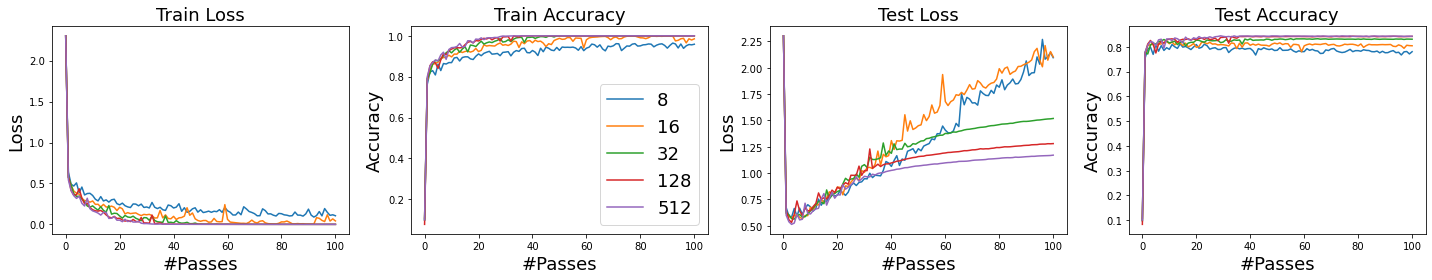

In [14]:
f, ax = plt.subplots(1, 4, figsize=(20, 4))

ax[0].set_title('Train Loss', fontsize=18)
ax[1].set_title('Train Accuracy', fontsize=18)
ax[2].set_title('Test Loss', fontsize=18)
ax[3].set_title('Test Accuracy', fontsize=18)

for i in range(4):
    ax[i].set_xlabel('#Passes', fontsize=18)
    ax[i].set_ylabel('Loss' if i%2==0 else 'Accuracy', fontsize=18)
    for h, log in hidden_size_logs.items():
        ax[i].plot(list(map(lambda x: x[i], log)), label=h)
        
ax[1].legend(fontsize=18)
plt.tight_layout()

#### 1.2
When the training accuracy is 100%, the model is said to interpolate the training data. What is the
smallest width at which we observe perfect interpolation of the training data?

**32 is the smallest width at which we see interpolation**

#### 1.3
As we vary the width of the network, at which training epoch do we observe perfect interpolation of
the data? That is, make a plot with h on the x-axis and number of passes over the data required for
interpolation on the y axis.

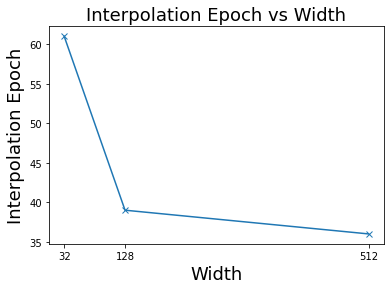

In [15]:
interpolation_epoch_value = []

for hidden_size in hidden_sizes:
    log = hidden_size_logs[hidden_size]
    train_accuracy = list(map(lambda x: x[1].item(), log))
    try:
        interpolation_epoch_value.append(train_accuracy.index(1))
    except ValueError as e:
        interpolation_epoch_value.append(-1)

f = plt.figure()
ax = f.gca()

ax.set_title('Interpolation Epoch vs Width', fontsize=18)
ax.set_xlabel('Width', fontsize=18)
ax.set_ylabel('Interpolation Epoch', fontsize=18)

interpolation_epoch_value = np.asarray(interpolation_epoch_value)
hidden_sizes = np.asarray(hidden_sizes)

# Now let's extract only the part of the data we're interested in...
x_filt = hidden_sizes[interpolation_epoch_value > -1]
y_filt = (interpolation_epoch_value[interpolation_epoch_value > -1]).astype(int)
ax.plot(x_filt, y_filt, 'x-')

ax.set_xticks(x_filt)

## 2. Divergent Learning Rate, Accuracy and Width

#### 2.1 
Find the divergent learning rate η∗ for width h ∈ [4, 8, 16, 32, 128, 512, 2048]. Make a plot for the divergent learning rate versus the hidden width.

In [39]:
hidden_sizes = [4, 8, 16, 32, 128, 512, 2048]
learning_rates = []

In [40]:
learning_rate = 0.01
learning_rates.append(learning_rate)

hidden_size = 4
ws = intialize_ws(hidden_size, n_class)
bs = initialize_bs(hidden_size, n_class)

_ = compute_logs(ws, bs, reg_param, verbose=True)

ws, bs = sgd_one_pass(ws, bs, X_train, y_train, reg_param, learning_rate, verbose=True)
_ = compute_logs(ws, bs, reg_param, verbose=True)

Train Loss = 2.303, Train Accuracy = 0.124, Test Loss = 2.303, Test Accuracy = 0.117
1.4621044326453378
1.9946212077286125
2.188290160071258
2.2673074699550444
2.2903342637293
2.2646656132070837
2.1035636986285033
1.8945605392492433
1.7045190959660383
1.6371252121000215
1.5706503565792471
1.5610587990509959
1.4428363601237224
1.2894367756875142
1.3289315551323706
1.2783734737657833
1.3040195461800386
1.3098727536752979
1.229342388631518
1.1851768984894018
1.1007731837999803
1.0931233074103104
1.0023980322681443
0.9756025283052179
0.998777254755458
0.9446234296111989
0.8794612793677193
1.0072491304920221
0.9866456339087731
1.0100517850363144
1.1039090411079666
1.0158672807237736
0.9025406167029669
0.9644502151316204
0.8613271149045321
0.8821630735740116
1.102523546364203
0.9035240123509657
1.0451258132625525
0.9088392632896937
0.8865732764537279
0.8471266561226818
0.7876959062020937
0.9362172896733943
0.7989035890233582
0.8858505090635214
0.8413130093114279
0.7123075687525289
0.87856470

In [41]:
learning_rate = 0.01
learning_rates.append(learning_rate)

hidden_size = 8
ws = intialize_ws(hidden_size, n_class)
bs = initialize_bs(hidden_size, n_class)

_ = compute_logs(ws, bs, reg_param, verbose=True)

ws, bs = sgd_one_pass(ws, bs, X_train, y_train, reg_param, learning_rate, verbose=True)
_ = compute_logs(ws, bs, reg_param, verbose=True)

Train Loss = 2.303, Train Accuracy = 0.114, Test Loss = 2.303, Test Accuracy = 0.121
1.4594962983238338
1.994896669061386
2.19375505919179
2.263830598568168
2.270548670023029
2.129709586081141
1.9362766437383325
1.903442909672524
1.6834396941810519
1.4901799456384752
1.318910067048513
1.2380481216851393
1.19663744118872
1.2546736612064526
1.1046192528545489
0.9473943424715875
1.0774741985711862
0.978620198861561
0.9417639093785614
0.8803898129023999
0.9062765063081857
0.816659021690723
0.8540408363701852
0.8591681221519685
0.799925091072663
0.808321502965813
0.8141060130245283
0.6791167051764908
0.8025217660919476
0.7160209528662224
0.7470291940656685
0.7507430452863255
0.72662505616599
0.5518993270339667
0.6008608999766666
0.5779985573999937
0.7315067201025783
0.7512895114694139
0.7173518127124143
0.8456169550107429
0.8356060093964157
0.9454311718636675
0.9651192072284233
0.7477398996106921
0.5784488049034594
0.5619160998259286
0.7108016128398765
0.8171880802933742
0.848595086537765
0

In [42]:
learning_rate = 0.01
learning_rates.append(learning_rate)

hidden_size = 16
ws = intialize_ws(hidden_size, n_class)
bs = initialize_bs(hidden_size, n_class)

_ = compute_logs(ws, bs, reg_param, verbose=True)

ws, bs = sgd_one_pass(ws, bs, X_train, y_train, reg_param, learning_rate, verbose=True)
_ = compute_logs(ws, bs, reg_param, verbose=True)

Train Loss = 2.303, Train Accuracy = 0.107, Test Loss = 2.303, Test Accuracy = 0.110
1.4586210769947818
1.995226417739537
2.1929056559375852
2.263722282457678
2.2899173843611567
2.2724305518860746
2.1058800048456305
1.875686551614814
1.5995967016659327
1.447633076281185
1.3343460819577724
1.1310162733890587
1.2435034250490513
1.1816860213231943
1.0875003096375828
1.0147646086683426
0.951172670716814
1.020679499985649
0.9815905852181919
0.8769080502232983
0.7114055748857689
0.705164166256284
0.6929650883418526
0.7869911148293648
0.7541833844337456
0.6953013365620873
0.8595848770148532
0.5987970263768012
0.6079001977077422
0.7571482515070442
0.6959483761535751
0.7415350028143547
0.762470332987473
0.7851127456058425
0.7642842542620728
0.8927166743641451
0.718240612196927
0.6616673362920175
0.7178821166474975
0.7970430961316594
0.7645088196181975
0.8064610026972202
0.7595335472893429
0.7026881578212822
0.7170782660264974
0.6927019856966086
0.6541970982914934
0.6362451882132276
0.7674625282

In [43]:
learning_rate = 0.01
learning_rates.append(learning_rate)

hidden_size = 32
ws = intialize_ws(hidden_size, n_class)
bs = initialize_bs(hidden_size, n_class)

_ = compute_logs(ws, bs, reg_param, verbose=True)

ws, bs = sgd_one_pass(ws, bs, X_train, y_train, reg_param, learning_rate, verbose=True)
_ = compute_logs(ws, bs, reg_param, verbose=True)

Train Loss = 2.303, Train Accuracy = 0.114, Test Loss = 2.303, Test Accuracy = 0.106
1.4604296819786085
1.9937657026718718
2.191738612974964
2.2644980935102224
2.2895176527289216
2.268097149501768
1.9772957633286015
1.7253355874293008
1.5172367079427904
1.417063096087028
1.3024711580989299
1.276871615517528
1.1530726089111902
0.9282455268589835
0.88789431617351
0.8767393161920373
0.7657869790510068
0.8415954182012605
0.7434935835940699
0.8007385331369903
0.7815702963515885
0.7044436682587145
0.9074608660344218
0.7428019483871825
0.7170108900729025
0.6346618663913212
0.5822804778476975
0.7509245387612579
0.6856550335613025
0.761151877735095
0.7144731935828339
0.635200774445079
0.5843186330780359
0.6548712174480074
0.6599587211427264
0.6314480233341946
0.6959560543330002
0.6195002837087029
0.6992840293436821
0.7155905467144729
0.7469620303700519
0.8447939909637416
0.8276317714134559
0.7244280582365361
0.7030355697453063
0.5787154100989578
0.6507923037288098
0.6620100353940508
0.680611058

In [44]:
learning_rate = 0.01
learning_rates.append(learning_rate)

hidden_size = 128
ws = intialize_ws(hidden_size, n_class)
bs = initialize_bs(hidden_size, n_class)

_ = compute_logs(ws, bs, reg_param, verbose=True)

ws, bs = sgd_one_pass(ws, bs, X_train, y_train, reg_param, learning_rate, verbose=True)
_ = compute_logs(ws, bs, reg_param, verbose=True)

Train Loss = 2.303, Train Accuracy = 0.078, Test Loss = 2.303, Test Accuracy = 0.076
1.4615504592571429
1.993241957408438
2.190435011942983
2.255443778915452
2.2705396121949706
2.0943142108643342
1.8783420196076466
1.660605759589135
1.476659261073228
1.3658297285344978
1.2922629823781664
1.1778248325790857
1.105667316084556
0.9671811102048473
0.8938494739315878
0.9126096957072981
0.763845309934718
0.8938048575197636
0.884066756582517
0.7949466909522835
0.7320578506948233
0.8341715149008695
0.7620635708638497
0.6729750230768966
0.6679829576279736
0.5775086873355579
0.6418161574479437
0.7701622527206765
0.8905306161587581
0.8510803330232642
0.753822768723063
0.7323974540171412
0.6052681837446096
0.5748896634061669
0.5410780550253043
0.5648009314544795
0.6367358209995782
0.663195898420038
0.5181604805123099
0.5913963662011166
0.65191183209491
0.7778110062106462
0.6129380100725589
0.6707763308776411
0.5895340868383555
0.6527199301089447
0.4628614797517581
0.5577811932761737
0.5869805070695

In [45]:
learning_rate = 0.01
learning_rates.append(learning_rate)

hidden_size = 512
ws = intialize_ws(hidden_size, n_class)
bs = initialize_bs(hidden_size, n_class)

_ = compute_logs(ws, bs, reg_param, verbose=True)

ws, bs = sgd_one_pass(ws, bs, X_train, y_train, reg_param, learning_rate, verbose=True)
_ = compute_logs(ws, bs, reg_param, verbose=True)

Train Loss = 2.303, Train Accuracy = 0.126, Test Loss = 2.303, Test Accuracy = 0.126
1.4597177920234474
1.9940502134518898
2.190872995862269
2.2585039596859384
2.2481070603276105
2.083544451197122
1.842461363755616
1.5807559849977881
1.5253958142286648
1.4443802453906855
1.2885429029203634
1.1424751591067674
1.0085218783668486
0.8590315342198536
0.7867350124903643
0.7553873750760918
0.7960617987758482
0.6999666190350569
0.8159961693810619
0.6760270732423118
0.7381686205686209
0.8338934980382535
0.7726005496909174
0.7737335917326233
0.8133573589896871
0.7540432487659275
0.6499986343472077
0.5741427273421201
0.6076657660052898
0.5063845632424301
0.6403783771069719
0.6160596527765757
0.7716337698911755
0.6116327248176433
0.6036100506602174
0.5945839970813396
0.6520596895284186
0.5566870498443773
0.491207179156509
0.6340719264201714
0.5213239625437053
0.6371497632453987
0.6881954979101522
0.5805454977857449
0.5538171840936916
0.5782052051292756
0.7328340628331363
0.7876827809270361
0.82410

In [46]:
learning_rate = 0.01
learning_rates.append(learning_rate)

hidden_size = 2048
ws = intialize_ws(hidden_size, n_class)
bs = initialize_bs(hidden_size, n_class)

_ = compute_logs(ws, bs, reg_param, verbose=True)

ws, bs = sgd_one_pass(ws, bs, X_train, y_train, reg_param, learning_rate, verbose=True)
_ = compute_logs(ws, bs, reg_param, verbose=True)

Train Loss = 2.303, Train Accuracy = 0.109, Test Loss = 2.303, Test Accuracy = 0.104
1.4576087718447308
1.9955924440802584
2.18941118636607
2.2518131439116575
2.104809765034614
1.8284063341332026
1.6012037905094947
1.4505866679854038
1.2702324828123666
1.093306054408796
1.0280606633569631
1.0477610348092168
1.0478427626107387
0.9047132104560268
0.777297268106388
0.762789229678752
0.8344420961062277
0.8793097110318278
0.7492191442031185
0.541014008323092
0.7649644099954688
0.8278679053239989
0.7244995259122148
0.7744482149184827
0.7516112766193254
0.6605136349838191
0.5452872280841438
0.5592623373339352
0.622515098381035
0.6505740423704861
0.6235394742942802
0.6820165318358403
0.5999144811476509
0.6157584757337607
0.5291017899188006
0.4938435750233573
0.5395718730974007
0.6090631946586
0.633781475399923
0.6080900613764938
0.6475392315504407
0.5737953565020454
0.5946843518509863
0.6877970313363403
0.595222965779592
0.6182343199745135
0.4442231472680893
0.5400556946961178
0.53876418983342

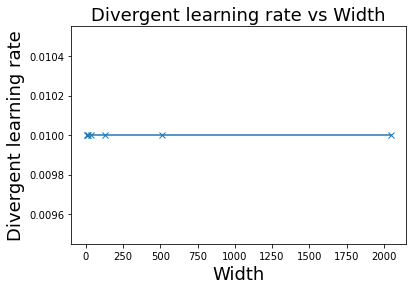

In [51]:
f = plt.figure()
ax = f.gca()

ax.set_title('Divergent learning rate vs Width', fontsize=18)
ax.set_ylabel('Divergent learning rate', fontsize=18)
ax.set_xlabel('Width', fontsize=18)

ax.plot(hidden_sizes, learning_rates, 'x-')
# ax.set_xticks(hidden_sizes)

#### 2.2
For a given width h, run SGD for 1 pass over the data with learning rate η ∈ [η∗h, η∗h/2, η∗h/4, η∗h/8],where η∗ h is from Part 2.1. 

Measure the test accuracy for each of these learning rates. Let Ah denote the best accuracy obtained here. Repeat this procedure for each of the widths considered in Part 2.1.

In [62]:
divisors = [1, 2, 4, 8]
num_passes = 1

if not os.path.exists(MLP_Q2_RESULTS_FILE):
    hidden_size_lr_logs = {}
    for i, hidden_size in enumerate(hidden_sizes):
        hidden_size_lr_logs[hidden_size] = {}
        learning_rate = learning_rates[i]

        for divisor in divisors:
            lr = learning_rate / divisor
            print(f'Hidden Size: {hidden_size}, Learning Rate: {lr}')
            hidden_size_lr_logs[hidden_size][lr] = []

            ws = intialize_ws(hidden_size, n_class)
            bs = initialize_bs(hidden_size, n_class)
            # hidden_size_lr_logs[hidden_size][lr].append(compute_logs(ws, bs, reg_param, verbose=False))
            compute_logs(ws, bs, reg_param, verbose=False)

            for j in range(num_passes):
                ws, bs = sgd_one_pass(ws, bs, X_train, y_train, reg_param, lr, verbose=False)
                hidden_size_lr_logs[hidden_size][lr].append(compute_logs(ws, bs, reg_param, verbose=False))

Hidden Size: 4, Learning Rate: 0.01
Hidden Size: 4, Learning Rate: 0.005
Hidden Size: 4, Learning Rate: 0.0025
Hidden Size: 4, Learning Rate: 0.00125
Hidden Size: 8, Learning Rate: 0.01
Hidden Size: 8, Learning Rate: 0.005
Hidden Size: 8, Learning Rate: 0.0025
Hidden Size: 8, Learning Rate: 0.00125
Hidden Size: 16, Learning Rate: 0.01
Hidden Size: 16, Learning Rate: 0.005
Hidden Size: 16, Learning Rate: 0.0025
Hidden Size: 16, Learning Rate: 0.00125
Hidden Size: 32, Learning Rate: 0.01
Hidden Size: 32, Learning Rate: 0.005
Hidden Size: 32, Learning Rate: 0.0025
Hidden Size: 32, Learning Rate: 0.00125
Hidden Size: 128, Learning Rate: 0.01
Hidden Size: 128, Learning Rate: 0.005
Hidden Size: 128, Learning Rate: 0.0025
Hidden Size: 128, Learning Rate: 0.00125
Hidden Size: 512, Learning Rate: 0.01
Hidden Size: 512, Learning Rate: 0.005
Hidden Size: 512, Learning Rate: 0.0025
Hidden Size: 512, Learning Rate: 0.00125
Hidden Size: 2048, Learning Rate: 0.01
Hidden Size: 2048, Learning Rate: 0.0

In [75]:
# Find all the test accuries for each lr
hidden_size_lr_logs_test_acc = {}
for h, lr_d in hidden_size_lr_logs.items():
    hidden_size_lr_logs_test_acc[h] = {}
    for lr, vals in lr_d.items():
        hidden_size_lr_logs_test_acc[h][lr] = vals[0][3].item()

Test accuracy for each hidden size and learning rate value

In [76]:
pp(hidden_size_lr_logs_test_acc)

{4: {0.00125: 0.28220000863075256,
     0.0025: 0.4514999985694885,
     0.005: 0.703000009059906,
     0.01: 0.6636000275611877},
 8: {0.00125: 0.3702999949455261,
     0.0025: 0.6700999736785889,
     0.005: 0.7125999927520752,
     0.01: 0.7164999842643738},
 16: {0.00125: 0.35910001397132874,
      0.0025: 0.6927000284194946,
      0.005: 0.7829999923706055,
      0.01: 0.7782999873161316},
 32: {0.00125: 0.35749998688697815,
      0.0025: 0.7128000259399414,
      0.005: 0.7821999788284302,
      0.01: 0.7835999727249146},
 128: {0.00125: 0.41190001368522644,
       0.0025: 0.7190999984741211,
       0.005: 0.7860000133514404,
       0.01: 0.7630000114440918},
 512: {0.00125: 0.4494999945163727,
       0.0025: 0.7433000206947327,
       0.005: 0.8004999756813049,
       0.01: 0.7759000062942505},
 2048: {0.00125: 0.5026999711990356,
        0.0025: 0.7515000104904175,
        0.005: 0.7896000146865845,
        0.01: 0.730400025844574}}


#### 2.3
Make a plot of the best test accuracy Ah at the end of one pass over the data as the width h is varied.

In [81]:
# find the lr with the max test accuracy
hidden_size_lr_logs_test_acc_max = {}
for h, lr_d in hidden_size_lr_logs_test_acc.items():
    max_key = max(lr_d, key=lr_d.get)
    hidden_size_lr_logs_test_acc_max[h] = lr_d[max_key]

Max accuracy for each hidden size

In [82]:
pp(hidden_size_lr_logs_test_acc_max)

{4: 0.703000009059906,
 8: 0.7164999842643738,
 16: 0.7829999923706055,
 32: 0.7835999727249146,
 128: 0.7860000133514404,
 512: 0.8004999756813049,
 2048: 0.7896000146865845}


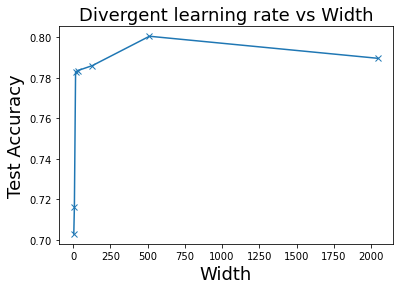

In [86]:
f = plt.figure()
ax = f.gca()

ax.set_title('Divergent learning rate vs Width', fontsize=18)
ax.set_ylabel('Test Accuracy', fontsize=18)
ax.set_xlabel('Width', fontsize=18)

ax.plot(hidden_sizes, list(hidden_size_lr_logs_test_acc_max.values()), 'x-')